In [1]:
from fish_helpers import *

In [2]:
md_path = '/hybedata/Images/Zach/Microscope/Chromatic_2019Aug08/beads_1/'
md = Metadata(md_path)

In [3]:
def find_beads_3D(Input, bead_template, match_threshold=0.65, upsamp_factor = 5):
    """
    3D registration from sparse bead images.
    Parameters
    ----------
    fnames_dict : dict
        Dictionary (hybe name:list filenames) to load bead images
    bead_template : numpy.array
        Array of normalized values of 'average bead' intensities.
        This helps to not pick up noisy spots/hot pixels.
    ref_reference : str - default('hybe1')
        Which hybe is the reference destination to map source hybes onto.
    max_dist : int - default(50)
        The maximum distanced allowed between beads found when pairing 
        beads between multiple hybes.
    match_threshold : float - default(0.75)
        The similarity threshold between bead_template and images to 
        consider potential beads.
    Returns
    -------
    tforms : dict
        Dictionary of translation vectors (x, y, z)? maybe (y, x, z)
    """
    pos = Input['posnames']
    print(pos)
    fnames_list = Input['fname_dicts'][pos]
    ref_stk = np.stack([io.imread(i) for i in fnames_list], axis=2).astype('float')
    ref_match = match_template(ref_stk, bead_template, pad_input=True)
    ref_beads = peak_local_max(ref_match, threshold_abs=match_threshold)
    upsamp_bead = resize(bead_template[2:5, 2:5, 1:4],
                         (3*upsamp_factor, 3*upsamp_factor, 3*upsamp_factor),
                         mode='constant',anti_aliasing=False)
    subpixel_beads = []
    for y, x, z in ref_beads:
        substk = ref_stk[y-5:y+6, x-5:x+6, z-2:z+3]
        if substk.shape[0] != 11 or substk.shape[1] != 11:
            continue # candidate too close to edge
        try:
            upsamp_substk = resize(substk,
                                   (substk.shape[0]*upsamp_factor,
                                    substk.shape[1]*upsamp_factor,
                                    substk.shape[2]*upsamp_factor),
                                   mode='constant',anti_aliasing=False)
        except:
            continue
        bead_match = match_template(upsamp_substk,
                                    upsamp_bead, pad_input=True)
        yu, xu, zu = np.where(bead_match==bead_match.max())
        yu = (yu[0]-int(upsamp_substk.shape[0]/2))/upsamp_factor
        xu = (xu[0]-int(upsamp_substk.shape[1]/2))/upsamp_factor
        zu = (zu[0]-int(upsamp_substk.shape[2]/2))/upsamp_factor
        ys, xs, zs = (yu+y, xu+x, zu+z)
        subpixel_beads.append((ys, xs, zs))

    return subpixel_beads,pos

In [7]:
Color_dict = {}
Bead_dict = {}
colors = md.image_table.Channel.unique()
poses = md.image_table.Position.unique()
acq = 'bead1'
ncpu = 6
bead = np.zeros((7, 7, 5))
bead[3, 3, 2] = 1
bead = gaussian(bead, (1.5, 1.5, 0.85))
Ave_Bead = bead/bead.max()
Color_dict = {}
for color in colors:
    print(color)
    Color_dict[color] = {}
    Input = [ {'fname_dicts': md.stkread(Channel=color, Position=pos,
                                     fnames_only=True), 'posnames': pos} for pos in poses]
    pfunc = partial(find_beads_3D,bead_template=Ave_Bead)
    with multiprocessing.Pool(ncpu) as p:
        for subpixel_beads,pos in p.imap(pfunc, Input, chunksize=1):
            Color_dict[color][pos] = subpixel_beads
            pickle.dump(Color_dict,open(os.path.join(md_path,'beads.pkl'),'wb'))

FarRed
TL_site4_1_4
TL_site2_1_2
TL_site3_1_3
TL_site1_1_1
TL_site5_1_5
TL_site6_1_6
TL_site7_1_7
TL_site8_1_8
TL_site9_1_9
TL_site10_1_10
TL_site11_2_1
TL_site12_2_2
TL_site13_2_3
TL_site18_2_8
TL_site19_2_9
TL_site20_2_10
TL_site21_3_1
TL_site22_3_2
TL_site23_3_3
TL_site24_3_4
TL_site25_3_5
TL_site26_3_6
TL_site27_3_7
TL_site28_3_8
TL_site29_3_9
TL_site30_3_10
TL_site31_4_1
TL_site32_4_2
TL_site33_4_3
TL_site34_4_4
TL_site35_4_5
TL_site36_4_6
TL_site37_4_7
TL_site38_4_8
TL_site39_4_9
TL_site40_4_10
TL_site41_5_1
TL_site42_5_2
TL_site43_5_3
TL_site44_5_4
TL_site45_5_5
TL_site46_5_6
TL_site47_5_7
TL_site48_5_8
TL_site49_5_9
TL_site50_5_10
TL_site51_6_1
TL_site52_6_2
TL_site53_6_3
TL_site54_6_4
TL_site55_6_5
TL_site56_6_6
TL_site57_6_7
TL_site58_6_8
TL_site59_6_9
TL_site60_6_10
TL_site61_7_1
TL_site62_7_2
TL_site63_7_3
TL_site64_7_4
TL_site65_7_5
TL_site66_7_6
TL_site67_7_7
TL_site68_7_8
TL_site69_7_9
TL_site70_7_10
TL_site71_8_1
TL_site72_8_2
TL_site73_8_3
TL_site74_8_4
TL_site75_8_5
T

In [6]:
Color_dict['FarRed'].keys()

dict_keys(['TL_site1_1_1', 'TL_site2_1_2', 'TL_site3_1_3', 'TL_site4_1_4', 'TL_site5_1_5', 'TL_site6_1_6', 'TL_site7_1_7', 'TL_site8_1_8', 'TL_site9_1_9', 'TL_site10_1_10', 'TL_site11_2_1', 'TL_site12_2_2', 'TL_site13_2_3', 'TL_site14_2_4', 'TL_site15_2_5', 'TL_site16_2_6', 'TL_site17_2_7', 'TL_site18_2_8', 'TL_site19_2_9', 'TL_site20_2_10', 'TL_site21_3_1', 'TL_site22_3_2', 'TL_site23_3_3', 'TL_site24_3_4', 'TL_site25_3_5', 'TL_site26_3_6', 'TL_site27_3_7', 'TL_site28_3_8', 'TL_site29_3_9', 'TL_site30_3_10', 'TL_site31_4_1', 'TL_site32_4_2', 'TL_site33_4_3', 'TL_site34_4_4', 'TL_site35_4_5', 'TL_site36_4_6', 'TL_site37_4_7', 'TL_site38_4_8', 'TL_site39_4_9', 'TL_site40_4_10', 'TL_site41_5_1', 'TL_site42_5_2', 'TL_site43_5_3', 'TL_site44_5_4', 'TL_site45_5_5', 'TL_site46_5_6', 'TL_site47_5_7', 'TL_site48_5_8', 'TL_site49_5_9', 'TL_site50_5_10', 'TL_site51_6_1', 'TL_site52_6_2', 'TL_site53_6_3', 'TL_site54_6_4', 'TL_site55_6_5', 'TL_site56_6_6', 'TL_site57_6_7', 'TL_site58_6_8', 'TL_sit

In [8]:
Bead_dict = {}
for pos in poses:
    Bead_dict[pos] = {}
    for color in colors:
        Bead_dict[pos][color] = Color_dict[color][pos]

In [18]:
from fish_helpers import *

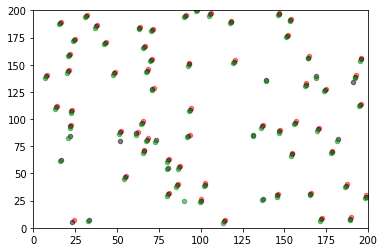

In [31]:
%matplotlib inline
s = 20
a = 0.5
xyz = np.stack(Bead_dict['TL_site1_1_1']['FarRed'],axis=0)
plt.scatter(xyz[:,0],xyz[:,1],c='r',s=s,alpha=a)
xyz = np.stack(Bead_dict['TL_site1_1_1']['Orange'],axis=0)
plt.scatter(xyz[:,0],xyz[:,1],c='k',s=s,alpha=a)
xyz = np.stack(Bead_dict['TL_site1_1_1']['Green'],axis=0)
plt.scatter(xyz[:,0],xyz[:,1],c='g',s=s,alpha=a)
plt.xlim([0,200])
plt.ylim([0,200])
plt.show()

In [38]:
#Apply old Chromatic to see if it fixes the problem
from scipy import interpolate
def interp_warp(img, x, y):
    """
    Apply chromatic abberation shifts to images.
    
    Parameters
    ----------
    img : ndarray
    x : array
    y : array
    
    Returns
    -------
    nimg : ndarray - same size as img but interpolated from x, y onto 0, 1, ... , img.shape
    """
    i2 = interpolate.interp2d(x, y, img)
    nimg = i2(range(img.shape[0]), range(img.shape[1]))
    return nimg


In [39]:
def find_beads_3D(stk, bead_template, match_threshold=0.65, upsamp_factor = 5):
    """
    3D registration from sparse bead images.
    Parameters
    ----------
    fnames_dict : dict
        Dictionary (hybe name:list filenames) to load bead images
    bead_template : numpy.array
        Array of normalized values of 'average bead' intensities.
        This helps to not pick up noisy spots/hot pixels.
    ref_reference : str - default('hybe1')
        Which hybe is the reference destination to map source hybes onto.
    max_dist : int - default(50)
        The maximum distanced allowed between beads found when pairing 
        beads between multiple hybes.
    match_threshold : float - default(0.75)
        The similarity threshold between bead_template and images to 
        consider potential beads.
    Returns
    -------
    tforms : dict
        Dictionary of translation vectors (x, y, z)? maybe (y, x, z)
    """
    ref_stk = stk
#     ref_stk = np.stack([io.imread(i) for i in fnames_list], axis=2).astype('float')
    ref_match = match_template(ref_stk, bead_template, pad_input=True)
    ref_beads = peak_local_max(ref_match, threshold_abs=match_threshold)
    upsamp_bead = resize(bead_template[2:5, 2:5, 1:4],
                         (3*upsamp_factor, 3*upsamp_factor, 3*upsamp_factor),
                         mode='constant',anti_aliasing=False)
    subpixel_beads = []
    for y, x, z in ref_beads:
        substk = ref_stk[y-5:y+6, x-5:x+6, z-2:z+3]
        if substk.shape[0] != 11 or substk.shape[1] != 11:
            continue # candidate too close to edge
        try:
            upsamp_substk = resize(substk,
                                   (substk.shape[0]*upsamp_factor,
                                    substk.shape[1]*upsamp_factor,
                                    substk.shape[2]*upsamp_factor),
                                   mode='constant',anti_aliasing=False)
        except:
            continue
        bead_match = match_template(upsamp_substk,
                                    upsamp_bead, pad_input=True)
        yu, xu, zu = np.where(bead_match==bead_match.max())
        yu = (yu[0]-int(upsamp_substk.shape[0]/2))/upsamp_factor
        xu = (xu[0]-int(upsamp_substk.shape[1]/2))/upsamp_factor
        zu = (zu[0]-int(upsamp_substk.shape[2]/2))/upsamp_factor
        ys, xs, zs = (yu+y, xu+x, zu+z)
        subpixel_beads.append((ys, xs, zs))

    return subpixel_beads

In [66]:
pos = md.image_table.Position.unique()[0]
bead = np.zeros((7, 7, 5))
bead[3, 3, 2] = 1
bead = gaussian(bead, (1.5, 1.5, 0.85))
Ave_Bead = bead/bead.max()
master_input = []
for color in colors:
    if color=='Green':
        x  = np.linspace(0, 2047, 2048)
        y  = np.linspace(0, 2047, 2048)
    else:
        x = chromatic_dict[color]['x']
        y = chromatic_dict[color]['y']
    master_input.append({'fname_dicts': md.stkread(Channel=color, Position=pos,fnames_only=True), 
                         'posnames': pos,'color':color,'x':x,'y':y,'Ave_Bead':Ave_Bead})

def chromatic_find_beads(Input):
    x = Input['x']
    y = Input['y']
    pos = Input['posnames']
    color = Input['color']
    Ave_Bead = Input['Ave_Bead']
    fnames_list = Input['fname_dicts'][pos]
    print(pos,color)
    stk = np.stack([io.imread(i) for i in fnames_list], axis=2).astype('float')
    for z in range(stk.shape[2]):
        stk[:,:,z] = interp_warp(stk[:,:,z], x, y)
    beads = find_beads_3D(stk, Ave_Bead)
    return beads,pos,color
ncpu = 4
chromatic_bead_dict = {}
# for pos in poses:
chromatic_bead_dict[pos]={}
with multiprocessing.Pool(ncpu) as p:
    for beads,pos,color in p.imap(chromatic_find_beads, master_input, chunksize=1):
        chromatic_bead_dict[pos][color] = beads
        pickle.dump(chromatic_bead_dict,open(os.path.join(md_path,'chromatic_beads.pkl'),'wb'))

TL_site1_1_1 FarRed
TL_site1_1_1 Orange
TL_site1_1_1 DeepBlue
TL_site1_1_1 Green


In [3]:
md_path = '/hybedata/Images/Zach/Microscope/Chromatic_2019Aug08/beads_1/'
md = Metadata(md_path)
chromatic_bead_dict = pickle.load(open(os.path.join(md_path,'chromatic_beads.pkl'),'rb'))

<IPython.core.display.Javascript object>


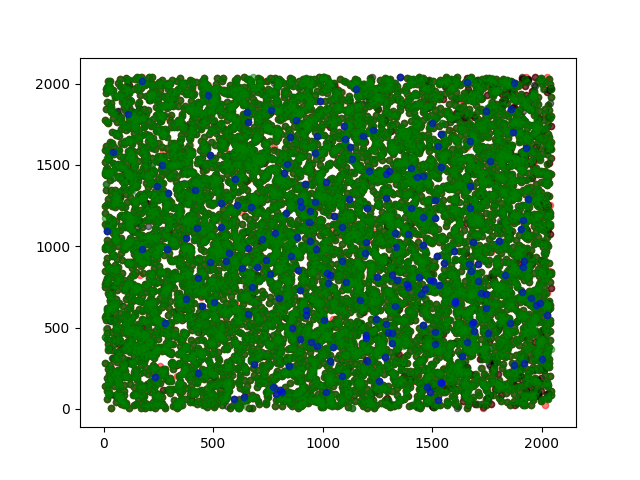

In [5]:
md_path = '/hybedata/Images/Zach/Microscope/Chromatic_2019Aug08/beads_1/'
md = Metadata(md_path)
chromatic_bead_dict = pickle.load(open(os.path.join(md_path,'chromatic_beads.pkl'),'rb'))
%matplotlib notebook
s = 20
a = 0.5
pos = md.image_table.Position.unique()[0]
bead_dictionary = chromatic_bead_dict
xyz = np.stack(bead_dictionary[pos]['FarRed'],axis=0)
plt.scatter(xyz[:,0],xyz[:,1],c='r',s=s,alpha=a)
xyz = np.stack(bead_dictionary[pos]['Orange'],axis=0)
plt.scatter(xyz[:,0],xyz[:,1],c='k',s=s,alpha=a)
xyz = np.stack(bead_dictionary[pos]['Green'],axis=0)
plt.scatter(xyz[:,0],xyz[:,1],c='g',s=s,alpha=a)
xyz = np.stack(bead_dictionary[pos]['DeepBlue'],axis=0)
plt.scatter(xyz[:,0],xyz[:,1],c='b',s=s,alpha=a)
plt.show()

<IPython.core.display.Javascript object>


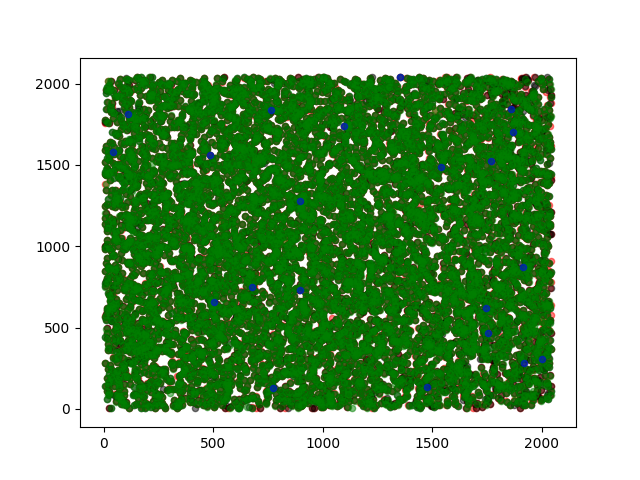

In [11]:
# md_path = '/hybedata/Images/Zach/Microscope/Chromatic_2019Aug08/beads_1/'
# md = Metadata(md_path)
bead_dict = pickle.load(open('/hybedata/Images/Zach/Microscope/Chromatic_2019Aug08/beads.pkl','rb'))
%matplotlib notebook
s = 20
a = 0.5
pos = md.image_table.Position.unique()[0]
bead_dictionary = bead_dict
xyz = np.stack(bead_dictionary['FarRed'][pos],axis=0)
plt.scatter(xyz[:,0],xyz[:,1],c='r',s=s,alpha=a)
xyz = np.stack(bead_dictionary['Orange'][pos],axis=0)
plt.scatter(xyz[:,0],xyz[:,1],c='k',s=s,alpha=a)
xyz = np.stack(bead_dictionary['Green'][pos],axis=0)
plt.scatter(xyz[:,0],xyz[:,1],c='g',s=s,alpha=a)
xyz = np.stack(bead_dictionary['DeepBlue'][pos],axis=0)
plt.scatter(xyz[:,0],xyz[:,1],c='b',s=s,alpha=a)
plt.show()

In [10]:
bead_dict.keys()

dict_keys(['FarRed', 'Orange', 'DeepBlue', 'Green'])

In [46]:
from hybescope_config.microscope_config import *
pos = md.image_table.Position.unique()[0]
acq = 'beads_1'
zs = md.image_table.Zindex.unique()
bead = np.zeros((7, 7, 5))
bead[3, 3, 2] = 1
bead = gaussian(bead, (1.5, 1.5, 0.85))
Ave_Bead = bead/bead.max()
chromatic_bead_dict = {}
chromatic_bead_dict[pos]={}
for color in colors:
    print(color)
    x = chromatic_dict[color]['x']
    y = chromatic_dict[color]['y']
    stk = np.zeros([2048,2048,len(zs)])
    for z in zs:
        img = md.stkread(Position=pos,Channel=color,acq=acq,Zindex=z)
        stk[:,:,z-1] = interp_warp(img[:,:,0], x, y)
    chromatic_bead_dict[pos][color] = find_beads_3D(stk, Ave_Bead)
    
    
    
    

FarRed
opening img_TL_site1_1_1_000000017_000000000_FarRed_000_017.tif

KeyboardInterrupt: 

In [42]:
img

{}

In [ ]:
def ensembl_bead_reg(bead_dict,pos, reg_ref='hybe1', max_dist=200,
                     dbscan_eps=3, dbscan_min_samples=20):
    """
    Calculate transformation to register 2 sets of images together
    Given a set of candidate bead coordinates (xyz) and a reference hybe find min-error translation.
    
    Parameters
    ----------
    bead_dict : dict
    pos: str
    
    Returns
    -------
    tform_dict : dict
      key - hybe name
      value - tuple(translation, residual, number beads)
    
    This task is trivial given a paired set of coordinates for source/destination beads. 
    The input to this function is unpaired so the first task is pairing beads. Given the 
    density of beads in relation to the average distance between beads it is not reliable to 
    simply use closest-bead-candidate pairing. However, for each bead in the destination we can find 
    all beads within from distance in the source set of beads and calculate the difference of all these pairs.
    Bead pairs that are incorrect have randomly distributed differences however correct bead pairs all 
    have very similar differences. So a density clustering of the differences is performed to identify 
    the set of bead pairings representing true bead pairs between source/destination.
    
    The best translation is found my minimizing the mean-squared error between source/destination after pairing.
    """
    # Final optimization objective function
    def error_func(translation):
        fit = np.add(translation, dest)
        fit_error = np.sqrt(np.subtract(ref, fit)**2)
        fit_error = np.mean(fit_error)
        return fit_error
    
    # Perform pairing by density clustering differences between all possible pairs
    bead_dict = bead_dict.copy()
    hybes = list(bead_dict.keys())
    ref = [i for i in hybes if reg_ref in i][0]
    ref_beadarray = bead_dict.pop(ref)
    if len(ref_beadarray)<dbscan_min_samples:
        return 'Failed position not enough reference beads found.'
    ref_beadarray = np.stack(ref_beadarray, axis=0)
    if ref_beadarray.shape[0]<dbscan_min_samples:
        return 'Failed position not enough reference beads found.'
    ref_tree = KDTree(ref_beadarray[:, :2])
    tform_dict = {ref: (np.array((0, 0, 0)), 0, float('inf'))}
    db_clusts = DBSCAN(min_samples=dbscan_min_samples, eps=dbscan_eps)
    for h, beadarray in bead_dict.items():
        if len(beadarray)<dbscan_min_samples:
            tform_dict[h] = 'Not enough bead pairs found.'
            continue
        beadarray = np.stack(beadarray, axis=0)
        t_est = []
        ref_beads = []
        dest_beads = []
        close_beads = ref_tree.query_ball_point(beadarray[:, :2], r=max_dist)
        for i, bead in zip(close_beads, beadarray):
            if len(i)==0:
                continue
            for nbor in i:
                t = ref_beadarray[nbor]-bead
                t_est.append(np.subtract(ref_beadarray[nbor], bead))
                ref_beads.append(ref_beadarray[nbor])
                dest_beads.append(bead)
        ref_beads = np.array(ref_beads)
        dest_beads = np.array(dest_beads)
        if len(t_est)<dbscan_min_samples:
            tform_dict[h] = 'Not enough bead pairs found.'
            continue
        t_est = np.stack(t_est, axis=0)
        db_clusts.fit(t_est)
        most_frequent_cluster = Counter(db_clusts.labels_)
        most_frequent_cluster.pop(-1)
        try:
            most_frequent_cluster = most_frequent_cluster.most_common(1)[0][0]
        except IndexError:
            tform_dict[h] = 'Not enough bead pairs found.'
            continue
        paired_beads_idx = db_clusts.labels_==most_frequent_cluster
        ref = ref_beads[paired_beads_idx]
        dest = dest_beads[paired_beads_idx]
        t_est = t_est[paired_beads_idx]
        tform_dict[h]=list(zip(ref_beads, dest_beads))
        
        # Optimize translation to map paired beads onto each other
        opt_t = scipy.optimize.fmin(error_func, np.mean(t_est, axis=0), full_output=True, disp=False)
        tform_dict[h] = (opt_t[0], opt_t[1], sum(paired_beads_idx))
    return tform_dict